In [1]:
import numpy as np
from operator import xor

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from classifier import *
from ntk import *
from Q_minimization import *

### Define Dimensions

In [186]:
n = 1000
m = 10
d = 10

### Define Dataset

In [187]:
def xor_label(row):
    _xor = xor(bool(row[1] > 0), bool(row[2] > 0))
    return 1.0 if _xor else -1.0

In [188]:
x = 2.0 * ((np.random.normal(size=(n, d - 1)) > 0) - 0.5)
x = np.concatenate([np.ones((n, 1)), x], axis=1)

y = np.array(list(map(xor_label, x))).reshape(-1,)

In [189]:
n_train = 100
x_train, x_test = x[: n_train, :], x[n_train:, :]
y_train, y_test = y[: n_train], y[n_train:]

### Utils

In [190]:
def plot_classifier(w, a, x, y):
    xmin = -1.2
    xmax = 1.2

    mesh_step = 0.02
    _x1 = np.arange(xmin, xmax, mesh_step)
    _x2 = np.arange(xmin, xmax, mesh_step)
    xx_1, xx_2 = np.meshgrid(_x1, _x2)

    input_ = np.c_[
        np.ones(xx_1.ravel().shape), 
        xx_1.ravel(), 
        xx_2.ravel(), 
        1.0 * ((np.random.normal(size=(len(xx_1.ravel()), d - 3)) > 0))
    ]
    
    activations = np.maximum(np.dot(w, input_.transpose()), 0)
    y_pred = np.dot(a, activations)

    plt.figure()
    z = np.reshape(np.sign(y_pred), xx_1.shape)
    plt.pcolormesh(xx_1, xx_2, z)

    plt.scatter([x_[1] for x_, y_ in zip(x, y) if y_ > 0], [x_[2] for x_, y_ in zip(x, y) if y_ > 0])
    plt.scatter([x_[1] for x_, y_ in zip(x, y) if y_ < 0], [x_[2] for x_, y_ in zip(x, y) if y_ < 0])
    plt.show()

### Solve L1

In [191]:
w_0 = np.random.normal(loc=0, scale=1, size=(m, d))
a_0 = np.random.normal(loc=0, scale=1, size=(m,))

In [192]:
w_opt_L1, a_opt_L1 = solver(x_train, y_train, w_0, a_0, m, d, obj='L1')
w_opt_L1, a_opt_L1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.378414752222392
            Iterations: 331
            Function evaluations: 38145
            Gradient evaluations: 330


(array([[-2.65258658e-09,  4.77206435e-01, -4.77206447e-01,
         -6.64616277e-09,  1.12983569e-09,  4.12573679e-09,
         -6.63197592e-09, -7.87932336e-09, -3.18821186e-09,
         -1.67754981e-09],
        [ 3.13501286e-09,  2.92915643e-01,  2.92915646e-01,
         -1.14428692e-08,  1.11095142e-08, -4.33562038e-09,
         -5.31471691e-09,  4.24700206e-09,  1.46360234e-09,
         -7.22795636e-09],
        [ 1.43516608e-06, -1.26521494e-03,  1.26562514e-03,
         -7.10733564e-07, -1.25451279e-06,  1.86750896e-06,
          3.07610258e-07,  1.41836694e-06,  2.19235020e-06,
         -1.20792420e-06],
        [-3.03574816e-09,  1.58581639e-01,  1.58581668e-01,
          9.80675843e-09, -1.03767245e-08,  1.13358997e-08,
          4.26092009e-09, -4.09978452e-09,  4.31974287e-09,
         -1.84657123e-08],
        [ 4.96982783e-09, -4.34750039e-01, -4.34750042e-01,
         -8.02757159e-09,  4.14593433e-09, -3.06068437e-09,
         -9.22806892e-09,  4.57426756e-09, -2.001972

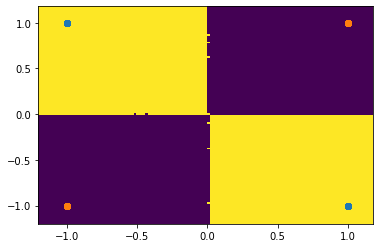

In [193]:
plot_classifier(w_opt_L1, a_opt_L1, x_train, y_train)

In [194]:
w_tilde_norms_opt_L1 = calc_w_tilde_norms(w_opt_L1, a_opt_L1)

In [195]:
minimal_margin(w_opt_L1, a_opt_L1, x_train, y_train)

0.999999968346963

### Create Symmetric Initialization

In [196]:
alpha = 1000
s = 0.8

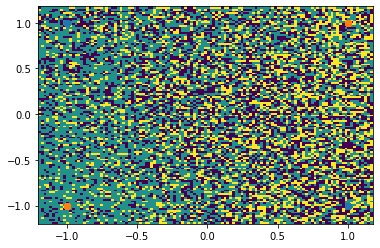

In [197]:
w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d)
plot_classifier(w_0, a_0, x, y)

### Train Full Model

In [198]:
def train(x_train, y_train, x_test, y_test, w_0, a_0, step_size, n_epochs):
    training_accuracy = []
    test_accuracy = []
    excess_l1_curve = []
    w_curve = []
    a_curve = []

    w, a = np.array(w_0), np.array(a_0)

    for epoch in range(n_epochs):
        w, a, gamma_tilde, gamma = update(w, a, x_train, y_train, epoch, step_size)
        w_curve.append(w)
        a_curve.append(a)
        
        training_accuracy.append(gamma_tilde)
        test_accuracy.append(evaluate(x_test, y_test, w, a))
        
        w_tilde_norms = calc_w_tilde_norms(w, a) / gamma
        excess_l1 = np.linalg.norm(w_tilde_norms, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1
        excess_l1_curve.append(excess_l1)


    return {
        'w': w_curve,
        'a': a_curve,
        'training_accuracy': training_accuracy,
        'test_accuracy': test_accuracy,
        'excess_l1_curve': excess_l1_curve
    }

In [199]:
def evaluate(x, y, w, a):
    activations = np.maximum(np.dot(w, x.transpose()), 0)
    y_pred = np.dot(a, activations)
    return sum(np.equal(np.sign(y_pred), np.sign(y))) / len(x)

In [211]:
alpha = 1000

results = {}
for s in [-0.9, 0, 0.9]:
    w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d, seed=0)
    results[s] = train(x_train, y_train, x_test, y_test, w_0, a_0, step_size=0.01, n_epochs=100000)

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


##### Check all models reach 100% train accuracy

In [212]:
for k in results.keys():
    w, a = results[k]['w'][-1], results[k]['a'][-1]
    print(k, evaluate(x_train, y_train, w, a))
    assert evaluate(x_train, y_train, w, a) == 1

-0.9 1.0
0 1.0
0.9 0.94


AssertionError: 

#####  Analyse

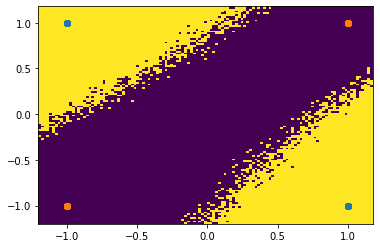

1.0

In [213]:
w, a = results[0]['w'][-1], results[0]['a'][-1]
plot_classifier(w, a, x_train, y_train)
evaluate(x_train, y_train, w, a)

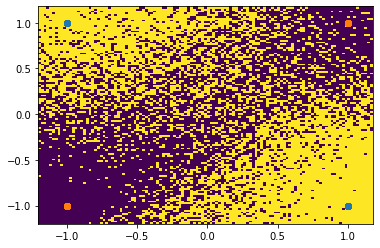

In [214]:
w, a = results[0.9]['w'][-1], results[0.9]['a'][-1]
plot_classifier(w, a, x_train, y_train)

(0.0, 10000000.0)

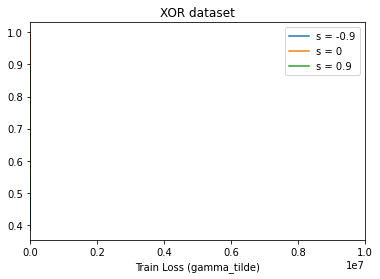

In [215]:
for k in results.keys():
    plot(results[k]['training_accuracy'], results[k]['test_accuracy'])

legend([f's = {k}' for k in results.keys()])
#yscale('log')
#xlim([0, 8000])
xlabel('Test Accuracy')
xlabel('Train Loss (gamma_tilde)')
title('XOR dataset')

xlim([0, 1e7])

In [45]:
results[0]['training_accuracy'][-1], results[0.9]['training_accuracy'][-1]

(92783.59902966161, 18079096.64915051)

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


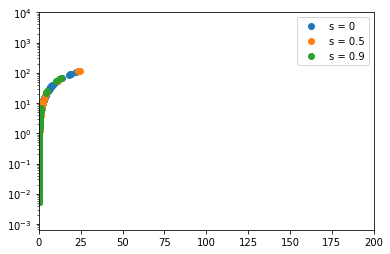

In [100]:
for k in results.keys():
    plot([2 * alpha/t for t in results[k]['training_accuracy']], results[k]['excess_l1_curve'], 'o')

yscale('log')
ylim([0, 1e4])
xlim([0, 200])
legend([f's = {k}' for k in results.keys()])

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


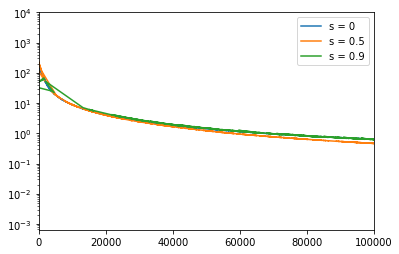

In [102]:
for k in results.keys():
    plot(results[k]['training_accuracy'], results[k]['excess_l1_curve'])

yscale('log')
ylim([0, 1e4])
xlim([0, 1e5])
legend([f's = {k}' for k in results.keys()])

In [103]:
relevant_weights = {}
for k in results.keys():
    train_acc = np.abs(np.array(results[k]['training_accuracy']) - 1e5)
    idx = np.argmin(train_acc)
    relevant_weights[k] = {'w': results[k]['w'][idx], 'a': results[k]['a'][idx]}
    print(results[k]['training_accuracy'][idx])

100000.28052941851
99999.4665572367
100057.82432863305


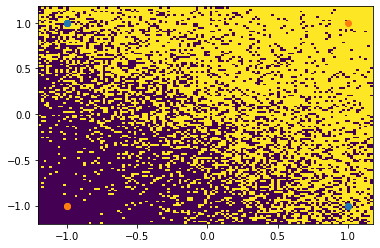

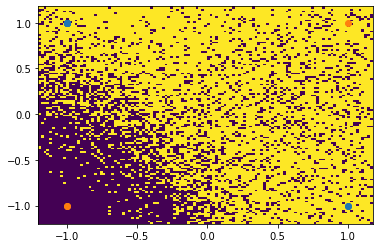

In [104]:
w, a = relevant_weights[0]['w'], relevant_weights[0]['a']
plot_classifier(w, a, x_train, y_train)

w, a = relevant_weights[0.9]['w'], relevant_weights[0.9]['a']
plot_classifier(w, a, x_train, y_train)

In [106]:
alpha = 10000

s_range = [0, 0.2, 0.5, 0.9, 0.99]
mu_range = [5, 10, 20, 50, 100, 200, 500, 1000] 

In [107]:
excess_l1_Q_curve = {}

x0 = np.random.normal(size=(m * (d + 1),))

for s_val in s_range:
    for mu_val in mu_range:
        mu = [mu_val] * m
        s_vec = [s_val] * m
        
        w_opt_Q, a_opt_Q = solver(x_train, y_train, w_0, a_0, m, d, obj='Q', mu=mu, s=s_vec, x0=x0, optim_tol=1e-9)
        _, _, _, gamma = update(w_opt_Q, a_opt_Q.reshape(1, -1), x_train, y_train, epoch=0, step_size=0)
        w_tilde_norms_Q = calc_w_tilde_norms(w_opt_Q, a_opt_Q) / gamma
        
        excess_l1_Q = np.linalg.norm(w_tilde_norms_Q, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1
        excess_l1_Q_curve.setdefault(s_val, []).append(excess_l1_Q)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -24.999999999735444
            Iterations: 19
            Function evaluations: 4219
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -49.999999999914664
            Iterations: 15
            Function evaluations: 3331
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -99.99999999990898
            Iterations: 13
            Function evaluations: 2887
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -249.9999999998816
            Iterations: 14
            Function evaluations: 3109
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -499.99999999971953
            Iterations: 15
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -25.12561697433975
            Iterations: 75
            Function evaluations: 16679
            Gradient evaluations: 75


Text(0.5, 1.0, 'Q_s^mu')

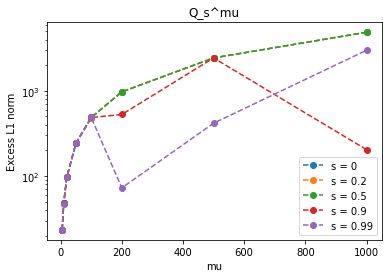

In [108]:
for k in excess_l1_Q_curve.keys():
    plot(mu_range, excess_l1_Q_curve[k], 'o--')

ylabel('Excess L1 norm')
yscale('log')
#ylim([0, 100])
#xlim([0, 20])
xlabel('mu')
legend([f's = {k}' for k in excess_l1_Q_curve.keys()])
title('Q_s^mu')